In [ ]:
import h5py, numpy as np
from tqdm import tqdm

h5_path = "/kaggle/input/rsna-patches/patches_16levels.h5"
BATCH = 4096

keep_ids = []
with h5py.File(h5_path, "r") as f:
    X = f["X"]
    n = len(X)
    print(f"[INFO] {n:,} patches à analyser")

    for start in tqdm(range(0, n, BATCH), desc="Filtrage par blocs", unit="bloc"):
        end = min(start + BATCH, n)
        batch = np.array(X[start:end], dtype=np.uint8)

        # séparer les deux moitiés 4-bit
        hi = batch >> 4
        lo = batch & 0x0F

        # variance (ou simple amplitude) par patch
        max_hi, min_hi = hi.max(axis=1), hi.min(axis=1)
        max_lo, min_lo = lo.max(axis=1), lo.min(axis=1)
        # garder si au moins un canal a plus d’un niveau
        mask = (max_hi > min_hi) | (max_lo > min_lo)

        keep_local = np.nonzero(mask)[0] + start
        keep_ids.extend(keep_local.tolist())

keep_ids = np.array(keep_ids, dtype=np.int32)
print(f"[INFO] {len(keep_ids):,} patches conservés sur {n:,}")

[INFO] 970,975 patches à analyser


Filtrage par blocs: 100%|██████████| 238/238 [13:43<00:00,  3.46s/bloc]


[INFO] 767,609 patches conservés sur 970,975


In [11]:
import h5py, numpy as np, pandas as pd, json
from sklearn.model_selection import train_test_split
from tqdm import tqdm

meta_path = "/kaggle/input/rsna-dataset/dataset.h5"

series_uids = []

with h5py.File(meta_path, "r") as f:
    meta = f["meta"]
    print(f"[INFO] Lecture de {len(meta):,} entrées 'meta'...")

    for i in tqdm(range(len(meta)), desc="Lecture meta", unit="serie"):
        entry = meta[i]

        if isinstance(entry, np.void):
            entry = tuple(entry.tolist())
        if isinstance(entry, (tuple, list)) and len(entry) >= 3:
            uid = entry[-1]
            if isinstance(uid, (bytes, np.bytes_)):
                uid = uid.decode(errors="ignore")
            uid = str(uid).strip()
        elif isinstance(entry, (bytes, np.bytes_)):
            try:
                data = json.loads(entry.decode("utf-8"))
                uid = data.get("series_uid", None)
            except Exception:
                uid = entry.decode(errors="ignore")
            uid = str(uid).strip()

        else:
            uid = str(entry).strip()

        if uid:
            series_uids.append(uid)

series_uids = np.unique(series_uids)
print(f"[INFO] {len(series_uids):,} SeriesInstanceUID uniques extraits.")




train_uids, test_uids = train_test_split(series_uids, test_size=0.2, random_state=42)
train_uids, val_uids = train_test_split(train_uids, test_size=0.25, random_state=42)

print(f"Train={len(train_uids)}, Val={len(val_uids)}, Test={len(test_uids)}")

uids_df = pd.DataFrame({
    "split": (["train"] * len(train_uids))
           + (["val"] * len(val_uids))
           + (["test"] * len(test_uids)),
    "SeriesInstanceUID": np.concatenate([train_uids, val_uids, test_uids])
})

print("\nAperçu corrigé :")
print(uids_df.head())


[INFO] Lecture de 4,348 entrées 'meta'...


Lecture meta: 100%|██████████| 4348/4348 [00:00<00:00, 9447.10serie/s]

[INFO] 4,348 SeriesInstanceUID uniques extraits.
Train=2608, Val=870, Test=870

Aperçu corrigé :
   split                                  SeriesInstanceUID
0  train  1.2.826.0.1.3680043.8.498.95905746070438796648...
1  train  1.2.826.0.1.3680043.8.498.10813507599485106154...
2  train  1.2.826.0.1.3680043.8.498.16175381153765107111...
3  train  1.2.826.0.1.3680043.8.498.51486084631657551343...
4  train  1.2.826.0.1.3680043.8.498.49308451203096270874...


In [12]:
import h5py, json
from tqdm import tqdm
import numpy as np

h5_path = "/kaggle/input/rsna-patches/patches_16levels.h5"

def patch_to_uid(k):
    with h5py.File(h5_path, "r") as f:
        meta = json.loads(bytes(f["meta"][:]).decode("utf-8"))
    uid, z, y, x, label = meta[k]
    return uid 

with h5py.File(h5_path, "r") as f:
    meta_all = json.loads(bytes(f["meta"][:]).decode("utf-8"))
print(f"[INFO] {len(meta_all):,} métadonnées chargées.")

splits = {"train": [], "val": [], "test": []}

for i in tqdm(keep_ids, desc="Assignation splits", unit="patch"):
    series_uid = str(meta_all[i][0])
    if series_uid in train_uids:
        splits["train"].append(i)
    elif series_uid in val_uids:
        splits["val"].append(i)
    elif series_uid in test_uids:
        splits["test"].append(i)

for name, ids in splits.items():
    print(f"{name:>5s} : {len(ids):,} patches")

if len(splits["train"]) > 0:
    i = np.random.choice(splits["train"])
    print("\nExemple :")
    print("Patch index :", i)
    print("SeriesInstanceUID :", meta_all[i][0])


[INFO] 970,975 métadonnées chargées.


Assignation splits: 100%|██████████| 767609/767609 [01:05<00:00, 11746.79patch/s]


train : 460,461 patches
  val : 151,416 patches
 test : 155,732 patches

Exemple :
Patch index : 970781
SeriesInstanceUID : 1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073


In [13]:
with h5py.File(h5_path, "r") as f:
    y_all = np.array(f["y"], dtype=np.uint8)

pos_ids = np.where(y_all == 1)[0]
neg_ids = np.where(y_all == 0)[0]
print(f"Positifs={len(pos_ids):,}, Négatifs={len(neg_ids):,}")


Positifs=3,090, Négatifs=967,885


In [14]:
def unpack_4bit(arr):
    arr = np.asarray(arr, dtype=np.uint8)
    hi = arr >> 4
    lo = arr & 0x0F
    return np.stack((hi, lo), axis=-1).ravel()

In [6]:
def balanced_epoch_gen(X_grp, y_grp, patch_ids,
                       batch_size=32, neg_ratio=4,
                       shuffle=True, normalize=True,
                       w_pos=1.0, w_neg=1.0):

    pos_ids = [i for i in patch_ids if int(y_grp[i]) == 1]
    neg_ids_all = [i for i in patch_ids if int(y_grp[i]) == 0]
    print(f"[INFO] {len(pos_ids)} pos, {len(neg_ids_all)} neg (pool)")

    while True:
        n_neg = neg_ratio * len(pos_ids)
        neg_ids = list(np.random.choice(neg_ids_all, size=n_neg, replace=False))
        epoch_ids = np.array(pos_ids + neg_ids)
        if shuffle:
            np.random.shuffle(epoch_ids)

        for start in range(0, len(epoch_ids), batch_size):
            end = min(start + batch_size, len(epoch_ids))
            batch_ids = epoch_ids[start:end]

            Xb, yb = [], []
            for i in batch_ids:
                flat = X_grp[i]
                vals = unpack_4bit(flat)[:64**3].reshape((64, 64, 64))
                if normalize:
                    vals = vals.astype(np.float32) / 15.0
                Xb.append(vals[..., np.newaxis])
                yb.append(int(y_grp[i]))

            Xb = np.stack(Xb)
            yb = np.array(yb, dtype=np.uint8)
            sw = np.where(yb == 1, w_pos, w_neg).astype(np.float32)
            yield Xb, yb, sw


def patch_generator(X_grp, y_grp, patch_ids,
                    batch_size=32, shuffle=True,
                    normalize=True, w_pos=1.0, w_neg=1.0):

    ids = np.array(patch_ids)
    n = len(ids)

    while True:
        if shuffle:
            np.random.shuffle(ids)

        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_ids = ids[start:end]

            Xb, yb = [], []
            for i in batch_ids:
                flat = X_grp[i]
                vals = unpack_4bit(flat)[:64**3].reshape((64, 64, 64))
                if normalize:
                    vals = vals.astype(np.float32) / 15.0
                Xb.append(vals[..., np.newaxis])
                yb.append(int(y_grp[i]))

            Xb = np.stack(Xb)
            yb = np.array(yb, dtype=np.uint8)
            sw = np.where(yb == 1, w_pos, w_neg).astype(np.float32)
            yield Xb, yb, sw

In [7]:
h5 = h5py.File(h5_path, "r")
X_grp_patch = h5["X"]
y_grp_patch = h5["y"]

batch_size = 32
neg_ratio = 4
w_pos = 2.0
w_neg = 1.0 / neg_ratio
class_weights = {0: w_neg, 1: w_pos}
print("class_weights:", class_weights)

train_gen = balanced_epoch_gen(X_grp_patch, y_grp_patch, splits["train"],
                               batch_size=batch_size, neg_ratio=neg_ratio,
                               shuffle=True, w_pos=w_pos, w_neg=w_neg)

val_gen = patch_generator(X_grp_patch, y_grp_patch, splits["val"],
                          batch_size=batch_size, shuffle=False)


class_weights: {0: 0.25, 1: 2.0}


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

input_shape = (64, 64, 64, 1)
EPS = 1e-7

def f1_tf(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred >= 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + EPS)
    recall = tp / (tp + fn + EPS)
    return 2 * precision * recall / (precision + recall + EPS)

def build_model():
    m = models.Sequential([
        layers.Conv3D(32, 3, padding="same", activation="relu", input_shape=input_shape),
        layers.BatchNormalization(), layers.MaxPooling3D(2),
        layers.Conv3D(64, 3, padding="same", activation="relu"),
        layers.BatchNormalization(), layers.MaxPooling3D(2),
        layers.Conv3D(128, 3, padding="same", activation="relu"),
        layers.BatchNormalization(), layers.MaxPooling3D(2),
        layers.Conv3D(256, 3, padding="same", activation="relu"),
        layers.BatchNormalization(), layers.GlobalAveragePooling3D(),
        layers.Dense(128, activation="relu"), layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc"),
                       tf.keras.metrics.Precision(name="precision"),
                       tf.keras.metrics.Recall(name="recall"), f1_tf])
    return m

model = build_model()
model.summary()


2025-10-22 21:22:47.594027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761168167.994775      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761168168.116749      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761168184.881318      37 gpu_device.cc:2022] Created device /job:localhost/repl

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 64, 64, 64, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 32, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 32, 32, 32, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 16, 16, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 16, 16, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 16,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 8, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 8, 8, 8, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 8, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,197,505 (4.57 MB)

 Trainable params: 1,196,545 (4.56 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score, confusion_matrix
from tqdm import tqdm
import numpy as np

class RandomValSubset(Callback):
    def __init__(self, X_grp, y_grp, all_val_ids,
                 batch_size=32, frac=0.01, threshold=0.5):
        """
        Validation rapide aléatoire à chaque fin d’époque.
        - frac : proportion du set val utilisée (ex: 0.01 = 1%)
        - threshold : seuil de classification binaire
        """
        self.X_grp = X_grp
        self.y_grp = y_grp
        self.all_val_ids = np.array(all_val_ids)
        self.batch_size = batch_size
        self.frac = frac
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        n_all = len(self.all_val_ids)
        n_sub = max(self.batch_size, int(self.frac * n_all))
        subset = np.random.choice(self.all_val_ids, n_sub, replace=False)

        def unpack_4bit(arr):
            arr = np.asarray(arr, dtype=np.uint8)
            hi = arr >> 4
            lo = arr & 0x0F
            return np.stack((hi, lo), axis=-1).ravel()

        y_true, y_prob = [], []

        print(f"\n[Validation rapide] Époque {epoch+1} — {n_sub} patches (≈{100*self.frac:.1f}%)")
        for start in tqdm(range(0, n_sub, self.batch_size),
                          desc=f"Validation {epoch+1}",
                          unit="batch",
                          leave=False):
            end = min(start + self.batch_size, n_sub)
            batch_ids = subset[start:end]

            # reconstruction des cubes 3D
            Xb = []
            for i in batch_ids:
                flat = self.X_grp[i]
                vals = unpack_4bit(flat)[:64**3].reshape((64, 64, 64))
                Xb.append(vals[..., np.newaxis])
            Xb = np.array(Xb, dtype=np.float32) / 15.0

            yb = np.array([int(self.y_grp[i]) for i in batch_ids], dtype=np.int32)
            pb = self.model.predict(Xb, verbose=0).ravel()
            y_true.append(yb)
            y_prob.append(pb)

        y_true = np.concatenate(y_true)
        y_prob = np.concatenate(y_prob)
        y_hat = (y_prob >= self.threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
        recall = tp / (tp + fn + 1e-9)
        precision = tp / (tp + fp + 1e-9)
        auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) == 2 else np.nan
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        specificity = tn / (tn + fp + 1e-9)
        bal_acc = 0.5 * (recall + specificity)

        print(
            f"[Validation {epoch+1}] "
            f"AUC={auc:.3f} | F1={f1:.3f} | Pr={precision:.3f} | Re={recall:.3f} "
            f"| Sp={specificity:.3f} | BA={bal_acc:.3f} "
            f"| TP={tp} FP={fp} FN={fn} TN={tn}"
        )

        logs = logs or {}
        logs["val_auc"] = auc
        logs["val_f1"] = f1
        logs["val_precision"] = precision
        logs["val_recall"] = recall
        logs["val_bal_acc"] = bal_acc


In [10]:
steps_per_epoch = 200  # petit test rapide
callbacks = [RandomValSubset(X_grp_patch, y_grp_patch, splits["val"], batch_size=batch_size, frac=0.003)]
history = model.fit(
    train_gen,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    verbose=1
)

[INFO] 1860 pos, 458601 neg (pool)
Epoch 1/20


I0000 00:00:1761168228.889939     104 service.cc:148] XLA service 0x7c8cfc001f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761168228.891590     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761168228.891611     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761168229.931537     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-22 21:23:55.418075: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,32,32,32]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,32,32,32]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":f

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5870 - auc: 0.7774 - f1_tf: 0.2913 - loss: 0.3030 - precision: 0.3171 - recall: 0.9011
[Validation rapide] Époque 1 — 454 patches (≈0.3%)


[Validation 1] AUC=0.779 | F1=0.013 | Pr=0.007 | Re=1.000 | Sp=0.000 | BA=0.500 | TP=3 FP=451 FN=0 TN=0
200/200 ━━━━━━━━━━━━━━━━━━━━ 882s 4s/step - accuracy: 0.5871 - auc: 0.7776 - f1_tf: 0.2913 - loss: 0.3029 - precision: 0.3173 - recall: 0.9013 - val_auc: 0.7790 - val_f1: 0.0131 - val_precision: 0.0066 - val_recall: 1.0000 - val_bal_acc: 0.5000
Epoch 2/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6544 - auc: 0.8472 - f1_tf: 0.2756 - loss: 0.2506 - precision: 0.3535 - recall: 0.9459
[Validation rapide] Époque 2 — 454 patches (≈0.3%)


[Validation 2] AUC=0.786 | F1=0.013 | Pr=0.007 | Re=1.000 | Sp=0.000 | BA=0.500 | TP=3 FP=451 FN=0 TN=0
200/200 ━━━━━━━━━━━━━━━━━━━━ 787s 4s/step - accuracy: 0.6544 - auc: 0.8473 - f1_tf: 0.2756 - loss: 0.2506 - precision: 0.3536 - recall: 0.9459 - val_auc: 0.7857 - val_f1: 0.0131 - val_precision: 0.0066 - val_recall: 1.0000 - val_bal_acc: 0.5000
Epoch 3/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6657 - auc: 0.8592 - f1_tf: 0.2732 - loss: 0.2455 - precision: 0.3630 - recall: 0.9399
[Validation rapide] Époque 3 — 454 patches (≈0.3%)


[Validation 3] AUC=0.822 | F1=0.010 | Pr=0.005 | Re=1.000 | Sp=0.148 | BA=0.574 | TP=2 FP=385 FN=0 TN=67
200/200 ━━━━━━━━━━━━━━━━━━━━ 772s 4s/step - accuracy: 0.6658 - auc: 0.8592 - f1_tf: 0.2732 - loss: 0.2455 - precision: 0.3631 - recall: 0.9399 - val_auc: 0.8219 - val_f1: 0.0103 - val_precision: 0.0052 - val_recall: 1.0000 - val_bal_acc: 0.5741
Epoch 4/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6903 - auc: 0.8814 - f1_tf: 0.2763 - loss: 0.2258 - precision: 0.3862 - recall: 0.9443
[Validation rapide] Époque 4 — 454 patches (≈0.3%)


[Validation 4] AUC=0.915 | F1=0.026 | Pr=0.013 | Re=1.000 | Sp=0.673 | BA=0.836 | TP=2 FP=148 FN=0 TN=304
200/200 ━━━━━━━━━━━━━━━━━━━━ 772s 4s/step - accuracy: 0.6903 - auc: 0.8814 - f1_tf: 0.2763 - loss: 0.2257 - precision: 0.3863 - recall: 0.9443 - val_auc: 0.9148 - val_f1: 0.0263 - val_precision: 0.0133 - val_recall: 1.0000 - val_bal_acc: 0.8363
Epoch 5/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7232 - auc: 0.8857 - f1_tf: 0.2759 - loss: 0.2187 - precision: 0.4201 - recall: 0.9590
[Validation rapide] Époque 5 — 454 patches (≈0.3%)


[Validation 5] AUC=0.971 | F1=0.015 | Pr=0.008 | Re=1.000 | Sp=0.709 | BA=0.854 | TP=1 FP=132 FN=0 TN=321
200/200 ━━━━━━━━━━━━━━━━━━━━ 759s 4s/step - accuracy: 0.7232 - auc: 0.8858 - f1_tf: 0.2759 - loss: 0.2186 - precision: 0.4201 - recall: 0.9590 - val_auc: 0.9713 - val_f1: 0.0149 - val_precision: 0.0075 - val_recall: 1.0000 - val_bal_acc: 0.8543
Epoch 6/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7400 - auc: 0.9066 - f1_tf: 0.2643 - loss: 0.2019 - precision: 0.4267 - recall: 0.9548
[Validation rapide] Époque 6 — 454 patches (≈0.3%)


[Validation 6] AUC=0.886 | F1=0.022 | Pr=0.011 | Re=1.000 | Sp=0.615 | BA=0.808 | TP=2 FP=174 FN=0 TN=278
200/200 ━━━━━━━━━━━━━━━━━━━━ 765s 4s/step - accuracy: 0.7400 - auc: 0.9066 - f1_tf: 0.2643 - loss: 0.2019 - precision: 0.4267 - recall: 0.9548 - val_auc: 0.8861 - val_f1: 0.0225 - val_precision: 0.0114 - val_recall: 1.0000 - val_bal_acc: 0.8075
Epoch 7/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7701 - auc: 0.9208 - f1_tf: 0.2623 - loss: 0.1846 - precision: 0.4613 - recall: 0.9621
[Validation rapide] Époque 7 — 454 patches (≈0.3%)


[Validation 7] AUC=0.869 | F1=0.025 | Pr=0.013 | Re=1.000 | Sp=0.662 | BA=0.831 | TP=2 FP=153 FN=0 TN=299
200/200 ━━━━━━━━━━━━━━━━━━━━ 759s 4s/step - accuracy: 0.7701 - auc: 0.9208 - f1_tf: 0.2623 - loss: 0.1846 - precision: 0.4613 - recall: 0.9621 - val_auc: 0.8695 - val_f1: 0.0255 - val_precision: 0.0129 - val_recall: 1.0000 - val_bal_acc: 0.8308
Epoch 8/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7735 - auc: 0.9179 - f1_tf: 0.2656 - loss: 0.1860 - precision: 0.4687 - recall: 0.9596
[Validation rapide] Époque 8 — 454 patches (≈0.3%)


[Validation 8] AUC=0.978 | F1=0.022 | Pr=0.011 | Re=1.000 | Sp=0.606 | BA=0.803 | TP=2 FP=178 FN=0 TN=274
200/200 ━━━━━━━━━━━━━━━━━━━━ 770s 4s/step - accuracy: 0.7735 - auc: 0.9179 - f1_tf: 0.2656 - loss: 0.1860 - precision: 0.4687 - recall: 0.9596 - val_auc: 0.9779 - val_f1: 0.0220 - val_precision: 0.0111 - val_recall: 1.0000 - val_bal_acc: 0.8031
Epoch 9/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7780 - auc: 0.9209 - f1_tf: 0.2680 - loss: 0.1843 - precision: 0.4805 - recall: 0.9511
[Validation rapide] Époque 9 — 454 patches (≈0.3%)


[Validation 9] AUC=0.861 | F1=0.000 | Pr=0.000 | Re=0.000 | Sp=0.916 | BA=0.458 | TP=0 FP=38 FN=1 TN=415
200/200 ━━━━━━━━━━━━━━━━━━━━ 737s 4s/step - accuracy: 0.7779 - auc: 0.9209 - f1_tf: 0.2680 - loss: 0.1843 - precision: 0.4804 - recall: 0.9511 - val_auc: 0.8609 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_bal_acc: 0.4581
Epoch 10/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7789 - auc: 0.9217 - f1_tf: 0.2540 - loss: 0.1855 - precision: 0.4646 - recall: 0.9657
[Validation rapide] Époque 10 — 454 patches (≈0.3%)


[Validation 10] AUC=0.943 | F1=0.077 | Pr=0.040 | Re=1.000 | Sp=0.681 | BA=0.840 | TP=6 FP=143 FN=0 TN=305
200/200 ━━━━━━━━━━━━━━━━━━━━ 735s 4s/step - accuracy: 0.7790 - auc: 0.9218 - f1_tf: 0.2541 - loss: 0.1855 - precision: 0.4647 - recall: 0.9657 - val_auc: 0.9427 - val_f1: 0.0774 - val_precision: 0.0403 - val_recall: 1.0000 - val_bal_acc: 0.8404
Epoch 11/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7887 - auc: 0.9324 - f1_tf: 0.2634 - loss: 0.1679 - precision: 0.4907 - recall: 0.9729
[Validation rapide] Époque 11 — 454 patches (≈0.3%)


[Validation 11] AUC=0.684 | F1=0.098 | Pr=0.054 | Re=0.500 | Sp=0.922 | BA=0.711 | TP=2 FP=35 FN=2 TN=415
200/200 ━━━━━━━━━━━━━━━━━━━━ 735s 4s/step - accuracy: 0.7887 - auc: 0.9325 - f1_tf: 0.2634 - loss: 0.1679 - precision: 0.4908 - recall: 0.9729 - val_auc: 0.6844 - val_f1: 0.0976 - val_precision: 0.0541 - val_recall: 0.5000 - val_bal_acc: 0.7111
Epoch 12/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7841 - auc: 0.9220 - f1_tf: 0.2549 - loss: 0.1833 - precision: 0.4759 - recall: 0.9338
[Validation rapide] Époque 12 — 454 patches (≈0.3%)


[Validation 12] AUC=0.862 | F1=0.040 | Pr=0.020 | Re=0.667 | Sp=0.787 | BA=0.727 | TP=2 FP=96 FN=1 TN=355
200/200 ━━━━━━━━━━━━━━━━━━━━ 729s 4s/step - accuracy: 0.7840 - auc: 0.9220 - f1_tf: 0.2549 - loss: 0.1833 - precision: 0.4759 - recall: 0.9338 - val_auc: 0.8618 - val_f1: 0.0396 - val_precision: 0.0204 - val_recall: 0.6667 - val_bal_acc: 0.7269
Epoch 13/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7834 - auc: 0.9283 - f1_tf: 0.2515 - loss: 0.1741 - precision: 0.4689 - recall: 0.9571
[Validation rapide] Époque 13 — 454 patches (≈0.3%)


[Validation 13] AUC=0.865 | F1=0.047 | Pr=0.024 | Re=1.000 | Sp=0.819 | BA=0.909 | TP=2 FP=82 FN=0 TN=370
200/200 ━━━━━━━━━━━━━━━━━━━━ 730s 4s/step - accuracy: 0.7834 - auc: 0.9283 - f1_tf: 0.2516 - loss: 0.1741 - precision: 0.4689 - recall: 0.9571 - val_auc: 0.8650 - val_f1: 0.0465 - val_precision: 0.0238 - val_recall: 1.0000 - val_bal_acc: 0.9093
Epoch 14/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8131 - auc: 0.9430 - f1_tf: 0.2551 - loss: 0.1522 - precision: 0.5139 - recall: 0.9727
[Validation rapide] Époque 14 — 454 patches (≈0.3%)


[Validation 14] AUC=0.817 | F1=0.021 | Pr=0.011 | Re=1.000 | Sp=0.797 | BA=0.898 | TP=1 FP=92 FN=0 TN=361
200/200 ━━━━━━━━━━━━━━━━━━━━ 753s 4s/step - accuracy: 0.8131 - auc: 0.9430 - f1_tf: 0.2551 - loss: 0.1523 - precision: 0.5139 - recall: 0.9726 - val_auc: 0.8168 - val_f1: 0.0213 - val_precision: 0.0108 - val_recall: 1.0000 - val_bal_acc: 0.8985
Epoch 15/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7769 - auc: 0.9185 - f1_tf: 0.2628 - loss: 0.1851 - precision: 0.4736 - recall: 0.9401
[Validation rapide] Époque 15 — 454 patches (≈0.3%)


[Validation 15] AUC=0.823 | F1=0.051 | Pr=0.027 | Re=0.500 | Sp=0.920 | BA=0.710 | TP=1 FP=36 FN=1 TN=416
200/200 ━━━━━━━━━━━━━━━━━━━━ 749s 4s/step - accuracy: 0.7770 - auc: 0.9186 - f1_tf: 0.2628 - loss: 0.1850 - precision: 0.4737 - recall: 0.9402 - val_auc: 0.8230 - val_f1: 0.0513 - val_precision: 0.0270 - val_recall: 0.5000 - val_bal_acc: 0.7102
Epoch 16/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8092 - auc: 0.9344 - f1_tf: 0.2483 - loss: 0.1650 - precision: 0.5059 - recall: 0.9578
[Validation rapide] Époque 16 — 454 patches (≈0.3%)


[Validation 16] AUC=0.962 | F1=0.051 | Pr=0.026 | Re=1.000 | Sp=0.752 | BA=0.876 | TP=3 FP=112 FN=0 TN=339
200/200 ━━━━━━━━━━━━━━━━━━━━ 720s 4s/step - accuracy: 0.8092 - auc: 0.9344 - f1_tf: 0.2483 - loss: 0.1650 - precision: 0.5059 - recall: 0.9578 - val_auc: 0.9616 - val_f1: 0.0508 - val_precision: 0.0261 - val_recall: 1.0000 - val_bal_acc: 0.8758
Epoch 17/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8037 - auc: 0.9394 - f1_tf: 0.2573 - loss: 0.1649 - precision: 0.5084 - recall: 0.9521
[Validation rapide] Époque 17 — 454 patches (≈0.3%)


[Validation 17] AUC=0.985 | F1=0.043 | Pr=0.022 | Re=1.000 | Sp=0.803 | BA=0.902 | TP=2 FP=89 FN=0 TN=363
200/200 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step - accuracy: 0.8037 - auc: 0.9394 - f1_tf: 0.2573 - loss: 0.1649 - precision: 0.5083 - recall: 0.9521 - val_auc: 0.9845 - val_f1: 0.0430 - val_precision: 0.0220 - val_recall: 1.0000 - val_bal_acc: 0.9015
Epoch 18/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7991 - auc: 0.9355 - f1_tf: 0.2612 - loss: 0.1644 - precision: 0.5059 - recall: 0.9571
[Validation rapide] Époque 18 — 454 patches (≈0.3%)


[Validation 18] AUC=1.000 | F1=0.023 | Pr=0.012 | Re=1.000 | Sp=0.812 | BA=0.906 | TP=1 FP=85 FN=0 TN=368
200/200 ━━━━━━━━━━━━━━━━━━━━ 724s 4s/step - accuracy: 0.7992 - auc: 0.9356 - f1_tf: 0.2612 - loss: 0.1643 - precision: 0.5060 - recall: 0.9571 - val_auc: 1.0000 - val_f1: 0.0230 - val_precision: 0.0116 - val_recall: 1.0000 - val_bal_acc: 0.9062
Epoch 19/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8213 - auc: 0.9403 - f1_tf: 0.2473 - loss: 0.1560 - precision: 0.5240 - recall: 0.9611
[Validation rapide] Époque 19 — 454 patches (≈0.3%)


[Validation 19] AUC=0.985 | F1=0.066 | Pr=0.034 | Re=1.000 | Sp=0.812 | BA=0.906 | TP=3 FP=85 FN=0 TN=366
200/200 ━━━━━━━━━━━━━━━━━━━━ 722s 4s/step - accuracy: 0.8213 - auc: 0.9403 - f1_tf: 0.2473 - loss: 0.1560 - precision: 0.5240 - recall: 0.9611 - val_auc: 0.9852 - val_f1: 0.0659 - val_precision: 0.0341 - val_recall: 1.0000 - val_bal_acc: 0.9058
Epoch 20/20


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8259 - auc: 0.9441 - f1_tf: 0.2495 - loss: 0.1489 - precision: 0.5324 - recall: 0.9708
[Validation rapide] Époque 20 — 454 patches (≈0.3%)


[Validation 20] AUC=0.985 | F1=0.028 | Pr=0.014 | Re=1.000 | Sp=0.848 | BA=0.924 | TP=1 FP=69 FN=0 TN=384
200/200 ━━━━━━━━━━━━━━━━━━━━ 736s 4s/step - accuracy: 0.8258 - auc: 0.9441 - f1_tf: 0.2496 - loss: 0.1489 - precision: 0.5323 - recall: 0.9707 - val_auc: 0.9845 - val_f1: 0.0282 - val_precision: 0.0143 - val_recall: 1.0000 - val_bal_acc: 0.9238


In [4]:
test_gen = patch_generator(
    X_grp_patch, y_grp_patch,
    patch_ids=[i for i, uid in enumerate(meta_uids) if uid in test_uids],
    batch_size=batch_size,
    normalize=True,
    shuffle=False
)

loss, acc = model.evaluate(test_gen, verbose=1)
print(f"Test loss = {loss:.4f}, Test accuracy = {acc:.4f}")


NameError: name 'patch_generator' is not defined

In [15]:
!pip install monai --quiet

In [16]:
import h5py, json, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from monai.networks.nets import resnet

In [17]:
class PatchDataset3D(Dataset):
    def __init__(self, h5_path, patch_ids, normalize=True):
        self.h5_path = h5_path
        self.patch_ids = patch_ids
        self.normalize = normalize
        self.file = None

    def __len__(self):
        return len(self.patch_ids)

    def __getitem__(self, idx):
        if self.file is None:
            self.file = h5py.File(self.h5_path, "r")
        i = self.patch_ids[idx]
        flat = self.file["X"][i]
        arr = np.frombuffer(flat, dtype=np.uint8)
        hi, lo = arr >> 4, arr & 0x0F
        patch = np.empty(len(arr)*2, dtype=np.uint8)
        patch[0::2], patch[1::2] = hi, lo
        patch = patch[:64**3].reshape(1, 64, 64, 64).astype(np.float32)
        if self.normalize:
            patch /= 15.0
        label = int(self.file["y"][i])
        return torch.from_numpy(patch), torch.tensor(label, dtype=torch.float32)


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from monai.networks.nets import resnet
import numpy as np
import h5py
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

# --- config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
MAX_TRAIN_BATCH = 500
MAX_VAL_BATCH = 80
BATCH_SIZE = 8
LR = 1e-4

h5_path = "/kaggle/input/rsna-patches/patches_16levels.h5"


with h5py.File(h5_path, "r") as f:
    y_all = np.array(f["y"][:])
train_labels = y_all[splits["train"]]
nb_pos = (train_labels == 1).sum()
nb_neg = (train_labels == 0).sum()
pos_weight = torch.tensor([nb_neg / nb_pos], device=device)
print(f"Ratio neg/pos = {nb_neg / nb_pos:.2f}")
train_ds = PatchDataset3D(h5_path, splits["train"])
val_ds   = PatchDataset3D(h5_path, splits["val"])

class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)



base = resnet.resnet10(
    spatial_dims=3,
    n_input_channels=1,
    num_classes=1,
    pretrained=True,
    shortcut_type="B",
    bias_downsample=False,
    feed_forward=False
)

for param in base.parameters():
    param.requires_grad = False

head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 1)
)

full_model = nn.Sequential(base, head).to(device)
optimizer = torch.optim.Adam(full_model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss()


Ratio neg/pos = 246.56


In [19]:
from torchinfo import summary

summary(
    full_model,
    input_size=(BATCH_SIZE, 1, 64, 64, 64),  # batch, channel, depth, height, width
    col_names=("input_size", "output_size", "num_params", "trainable"),
    depth=4
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
Sequential                                    [8, 1, 64, 64, 64]        [8, 1]                    --                        Partial
├─ResNet: 1-1                                 [8, 1, 64, 64, 64]        [8, 512]                  --                        False
│    └─Conv3d: 2-1                            [8, 1, 64, 64, 64]        [8, 64, 64, 64, 64]       (21,952)                  False
│    └─BatchNorm3d: 2-2                       [8, 64, 64, 64, 64]       [8, 64, 64, 64, 64]       (128)                     False
│    └─ReLU: 2-3                              [8, 64, 64, 64, 64]       [8, 64, 64, 64, 64]       --                        --
│    └─MaxPool3d: 2-4                         [8, 64, 64, 64, 64]       [8, 64, 32, 32, 32]       --                        --
│    └─Sequential: 2-5                        [8, 64, 32, 32, 32]       [8, 64, 32, 32, 32

In [20]:

for epoch in range(EPOCHS):
    full_model.train()
    running_loss = 0.0

    for b, (xb, yb) in enumerate(tqdm(train_dl, desc=f"Train {epoch+1}", unit="batch")):
        if b >= MAX_TRAIN_BATCH:
            break
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        pred = full_model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / (b + 1)
    print(f"[Époque {epoch+1}] Loss={avg_loss:.4f}")

    # --- évaluation validation ---
    y_true, y_pred = [], []
    with torch.no_grad():
        for b, (xb, yb) in enumerate(tqdm(val_dl, desc=f"Val {epoch+1}", unit="batch")):
            if b >= MAX_VAL_BATCH:
                break
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            pb = torch.sigmoid(full_model(xb))
            y_true.append(yb.cpu().numpy())
            y_pred.append(pb.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_bin = (y_pred >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_bin).ravel()
    acc = ((y_bin == y_true).mean())
    auc = roc_auc_score(y_true, y_pred) if len(np.unique(y_true)) == 2 else np.nan
    f1 = f1_score(y_true, y_bin)
    print(f"Validation — Acc={acc:.3f} | AUC={auc:.3f} | F1={f1:.3f}")
    print(f"TP={tp} | FP={fp} | TN={tn} | FN={fn}")

Train 1:   0%|          | 62/57558 [00:23<6:09:30,  2.59batch/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, precision_recall_curve, auc

# --- évaluation test ---
test_ds = PatchDataset3D(h5_path, splits["test"])
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

MAX_TEST_BATCH = 19467  # par exemple, teste sur 500 batchs

y_true, y_pred = [], []
full_model.eval()

with torch.no_grad():
    for b, (xb, yb) in enumerate(tqdm(test_dl, desc="Test", unit="batch")):
        if b >= MAX_TEST_BATCH:
            break
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        pb = torch.sigmoid(full_model(xb))
        y_true.append(yb.cpu().numpy())
        y_pred.append(pb.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_bin = (y_pred >= 0.5).astype(int)

Test:  17%|█▋        | 3319/19467 [17:32<1:07:28,  3.99batch/s]


[TEST] Acc=0.859 | AUC=0.910 | F1=0.039 | Pr=0.020 | Re=0.773
TP=228 | FP=11252 | TN=68453 | FN=67


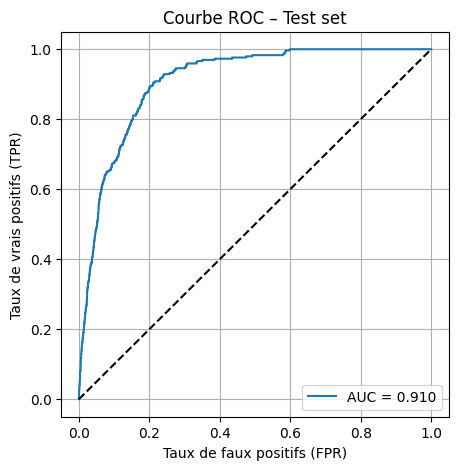

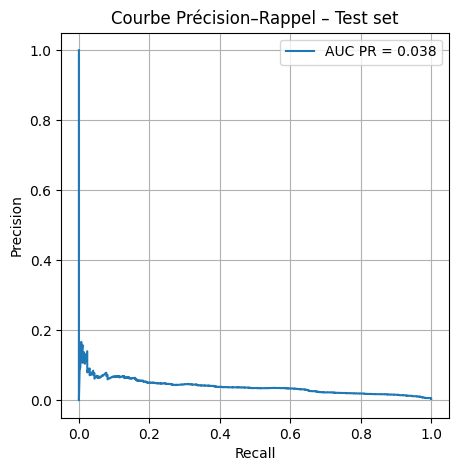

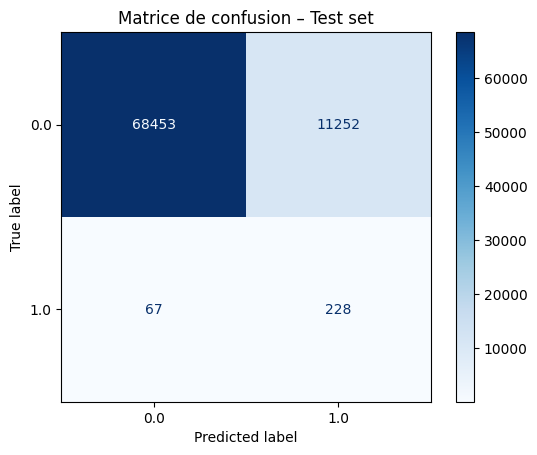

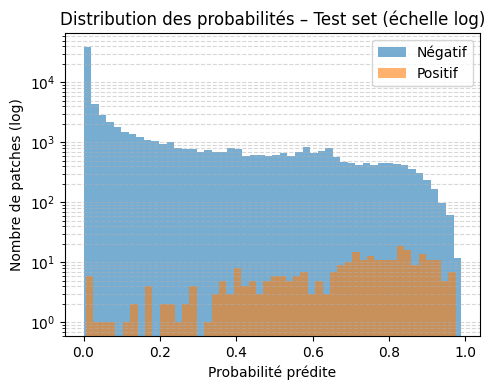

In [20]:
# --- métriques ---
tn, fp, fn, tp = confusion_matrix(y_true, y_bin).ravel()
acc = (y_bin == y_true).mean()
recall = tp / (tp + fn)
precision = tp / (tp + fp + 1e-8)
f1 = f1_score(y_true, y_bin)
auc_roc = roc_auc_score(y_true, y_pred)
print(f"\n[TEST] Acc={acc:.3f} | AUC={auc_roc:.3f} | F1={f1:.3f} | Pr={precision:.3f} | Re={recall:.3f}")
print(f"TP={tp} | FP={fp} | TN={tn} | FN={fn}")

# --- courbe ROC ---
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC – Test set")
plt.legend()
plt.grid(True)
plt.show()

# --- courbe précision/rappel ---
prec, rec, _ = precision_recall_curve(y_true, y_pred)
auc_pr = auc(rec, prec)
plt.figure(figsize=(5,5))
plt.plot(rec, prec, label=f"AUC PR = {auc_pr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Précision–Rappel – Test set")
plt.legend()
plt.grid(True)
plt.show()

# --- matrice de confusion ---
ConfusionMatrixDisplay.from_predictions(y_true, y_bin, cmap="Blues")
plt.title("Matrice de confusion – Test set")
plt.show()

# --- histogramme des probabilités (échelle log) ---
plt.figure(figsize=(5,4))
plt.hist(y_pred[y_true == 0], bins=50, alpha=0.6, label="Négatif", color="C0")
plt.hist(y_pred[y_true == 1], bins=50, alpha=0.6, label="Positif", color="C1")
plt.yscale("log")
plt.xlabel("Probabilité prédite")
plt.ylabel("Nombre de patches (log)")
plt.legend()
plt.title("Distribution des probabilités – Test set (échelle log)")
plt.grid(True, which="both", axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()